In [11]:
# ==================== 1. Import Libraries ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve, 
    PrecisionRecallDisplay, RocCurveDisplay, 
    average_precision_score
)
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import load_npz
import joblib
from xgboost import XGBClassifier

In [12]:
# ==================== 2. Load Data ====================
X = load_npz('X_final.npz')
y = pd.read_csv('y_target.csv', header=None).squeeze().values 
y = y[:X.shape[0]]
tfidf = joblib.load('tfidf_vectorizer.pkl')
numeric_feature_names = pd.read_csv('numeric_feature_names.csv', header=None)[0].tolist()

# Clean labels
y_clean = np.array([str(label).lower().strip() for label in y])
y_clean = np.where(y_clean == 'fraudulent', '1', y_clean)
y_clean = np.where(np.isin(y_clean, ['0', '1']), y_clean, '0')
y_final = LabelEncoder().fit_transform(y_clean)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Vectorizer features:", len(tfidf.get_feature_names_out()))
print("Numeric features:", numeric_feature_names)
print("Cleaned unique values:", np.unique(y_clean))
print("Final class distribution:", np.bincount(y_final))

X shape: (17879, 5034)
y shape: (17879,)
Vectorizer features: 5000
Numeric features: ['0', 'title', 'location', 'telecommuting', 'has_company_logo', 'has_questions', 'industry', 'function', 'has_salary', 'salary_fraud_risk', 'employment_type_Full-time', 'employment_type_Other', 'employment_type_Part-time', 'employment_type_Temporary', 'employment_type_Unknown', 'required_experience_Director', 'required_experience_Entry level', 'required_experience_Executive', 'required_experience_Internship', 'required_experience_Mid-Senior level', 'required_experience_Not Applicable', 'required_experience_Not specified', "required_education_Bachelor's Degree", 'required_education_Certification', 'required_education_Doctorate', 'required_education_High School or equivalent', "required_education_Master's Degree", 'required_education_Not specified', 'required_education_Professional', 'required_education_Some College Coursework Completed', 'required_education_Some High School Coursework', 'required_educat

In [13]:
# ==================== 3. Train-Test Split ====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_final, test_size=0.3, random_state=42, stratify=y_final
)

# ==================== 4. Apply SMOTE ====================
smote = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=5)
X_res, y_res = smote.fit_resample(X_train, y_train)



In [14]:
# ==================== 5. Train XGBoost Model ====================
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=3,  # Adjust based on imbalance
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)
xgb.fit(X_res, y_res)
# ==================== 6. Predict & Find Optimal Threshold (F1) ====================
y_proba = xgb.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
optimal_f1_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_f1_idx]
print(f"\nOptimal F1 Threshold: {optimal_threshold:.4f}")

y_pred = (y_proba >= optimal_threshold).astype(int)



C:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Optimal F1 Threshold: 0.3591



Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.96      0.97      0.97      5104
       Fraud       0.34      0.29      0.31       260

    accuracy                           0.94      5364
   macro avg       0.65      0.63      0.64      5364
weighted avg       0.93      0.94      0.94      5364


Confusion Matrix:
[[4956  148]
 [ 184   76]]

ROC AUC Score: 0.6792621171931517
Average Precision: 0.21824320347078885


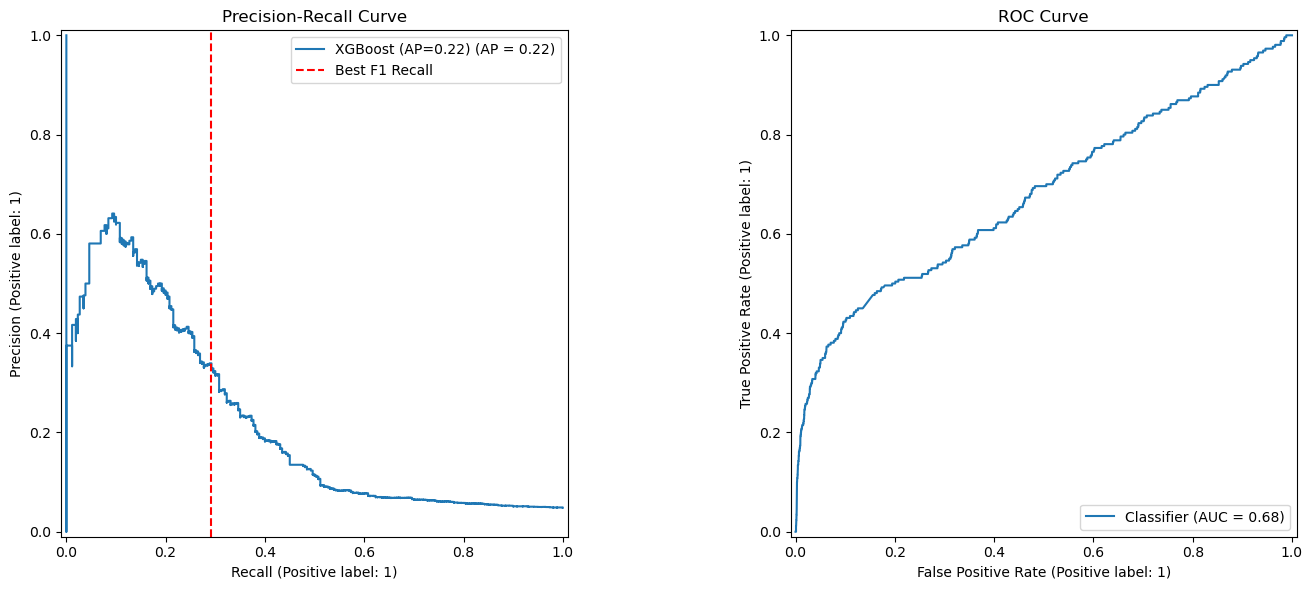


Total Business Cost: $18,548

Model saved successfully!


In [15]:
# ==================== 7. Evaluation ====================
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Average Precision:", average_precision_score(y_test, y_proba))

# ==================== 8. Visualizations ====================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

PrecisionRecallDisplay.from_predictions(
    y_test, y_proba, ax=ax1, 
    name=f"XGBoost (AP={average_precision_score(y_test, y_proba):.2f})"
)
ax1.set_title('Precision-Recall Curve')
ax1.axvline(x=recalls[optimal_f1_idx], color='r', linestyle='--', label='Best F1 Recall')
ax1.legend()

RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax2)
ax2.set_title('ROC Curve')
plt.tight_layout()
plt.show()

# ==================== 9. Cost Analysis ====================
conf_matrix = confusion_matrix(y_test, y_pred)
fraud_cost = 100
fp_cost = 1
total_cost = conf_matrix[1, 0] * fraud_cost + conf_matrix[0, 1] * fp_cost
print(f"\nTotal Business Cost: ${total_cost:,.0f}")

# ==================== 10. Save Model ====================
import joblib

# Save the vectorizer and model
joblib.dump(xgb, 'fraud_detection_xgb_model.pkl')
print("\nModel saved successfully!")
